In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
train = pd.read_json("/kaggle/input/facebook-hateful-meme-dataset/data/train.jsonl",lines=True)
test = pd.read_json("/kaggle/input/facebook-hateful-meme-dataset/data/test.jsonl",lines=True)
val = pd.read_json("/kaggle/input/facebook-hateful-meme-dataset/data/dev.jsonl",lines=True)
train.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [3]:
train.shape, test.shape, val.shape

((8500, 4), (1000, 3), (500, 4))

In [4]:
df = pd.concat([train, val])
df.shape

(9000, 4)

In [5]:
df

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...
498,9863,img/09863.png,0,diverse group of women


In [6]:
df.groupby(['label']).count()

,id,img,text
label,,,
0,5700,5700,5700
1,3300,3300,3300


In [7]:
import pandas as pd
from bs4 import BeautifulSoup

# Remove HTML syntax and statements from resume text
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text()
    return cleaned_text

# Apply remove_html_tags function to 'resume' column
df['text'] = df['text'].apply(remove_html_tags)
df['text'] = df['text'].astype('str')
df['label'] = df['label'].astype('str')
max_len = max(len(text) for text in df['text'])
print("Maximum length:", max_len)

/tmp/ipykernel_28/641380580.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


Maximum length: 433


In [8]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.0
    Uninstalling transformers-4.33.0:
      Successfully uninstalled transformers-4.33.0


In [9]:
from sklearn import preprocessing
X = df['text']

In [10]:
def data_creation(X,token):
    input_ids=[]
    attention_masks=[]
    for sent in tqdm(X):
        dbert_inps=token.encode_plus(str(sent),add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    print(len(input_ids),len(attention_masks))
    return input_ids,attention_masks
def extr(model_use):
    OP = []
    for batch in tqdm(range(0,input_ids.shape[0],64)):
        op = model_use(input_ids[batch:min(input_ids.shape[0],batch+64),:])[0][:,0,:]
        for i in op:
            OP.append(i.numpy())
    print(len(OP))
    OP = np.array(OP)
    return OP

# Funnel Net

In [11]:
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, TFFunnelModel

tokenizer = AutoTokenizer.from_pretrained("funnel-transformer/small")
model = TFFunnelModel.from_pretrained("funnel-transformer/small")
model_use = model
token_use = tokenizer
input_ids,attention_masks = data_creation(X,token_use)
OP_funnel = extr(model_use)
OP_funnel.shape

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFFunnelModel.

All the layers of TFFunnelModel were initialized from the model checkpoint at funnel-transformer/small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFFunnelModel for predictions without further training.


  0%|          | 0/9000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


9000 9000


  0%|          | 0/141 [00:00<?, ?it/s]

9000


(9000, 768)

# XLNET

In [12]:
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, TFXLNetModel

tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
model = TFXLNetModel.from_pretrained("xlnet-base-cased")
model_use = model
token_use = tokenizer
input_ids,attention_masks= data_creation(X,token_use)
OP_XLN = extr(model_use)
OP_XLN.shape

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


  0%|          | 0/9000 [00:00<?, ?it/s]

9000 9000


  0%|          | 0/141 [00:00<?, ?it/s]

9000


(9000, 768)

# BERT

In [13]:
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel,DistilBertTokenizer , RobertaTokenizer, TFRobertaModel
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')
model_use = model
token_use = tokenizer
input_ids,attention_masks = data_creation(X,token_use)
OP_BERT = extr(model_use)
OP_BERT.shape

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

  0%|          | 0/9000 [00:00<?, ?it/s]

9000 9000


  0%|          | 0/141 [00:00<?, ?it/s]

9000


(9000, 768)

# Modelling

In [14]:
from sklearn.preprocessing import OneHotEncoder
Y = np.array(df['label'])
Y = Y.reshape(Y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y = enc.transform(Y).toarray()
Y.shape

(9000, 2)

In [15]:
from tensorflow.keras.layers import LSTM,add
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout,MaxPool1D
from tensorflow.keras.layers import LSTM,add
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten,RNN
import tensorflow as tf
from tensorflow.keras.layers import Input

def create_model(max_len,num_classes,mod):
    inps1 = Input(shape = (768,), dtype='int64')
    inps2 = Input(shape = (768,), dtype='int64')
    inps3 = Input(shape = (768,), dtype='int64')
    dense_1 = Dense(2048,activation='relu'  )(inps1)
    dense_1 = Dense(1024,activation='relu'  )(dense_1)
    dense_1 = Dense(1024,activation='relu'  )(dense_1)
    dense_1 = Dense(512,activation='relu'  )(dense_1)
    
    dense_2 = Dense(2048,activation='relu'  )(inps2)
    dense_2 = Dense(1024,activation='relu'  )(dense_2)
    dense_2 = Dense(1024,activation='relu'  )(dense_2)
    dense_2 = Dense(512,activation='relu'  )(dense_2)
    
    dense_3 = Dense(2048,activation='relu'  )(inps3)
    dense_3 = Dense(1024,activation='relu'  )(dense_3)
    dense_3 = Dense(1024,activation='relu'  )(dense_3)
    dense_3 = Dense(512,activation='relu'  )(dense_3)
    
    concat =tf.keras.layers.Concatenate()([dense_3, dense_2, dense_1])
    dense_1 = Dense(512,activation='relu' )(concat)
    dense_1 = Dense(256,activation='relu' )(dense_1)
    dense_1 = Dense(256,activation='relu' )(dense_1)
    drOPout= Dropout(0.5)(dense_1)
    pred = Dense(2, activation='sigmoid')(drOPout)
    model = tf.keras.Model(inputs=[inps1,inps2,inps3], outputs=pred)
    return model
model = create_model(max_len,8,model_use)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 2048)         1574912     ['input_3[0][0]']                
                                                                                              

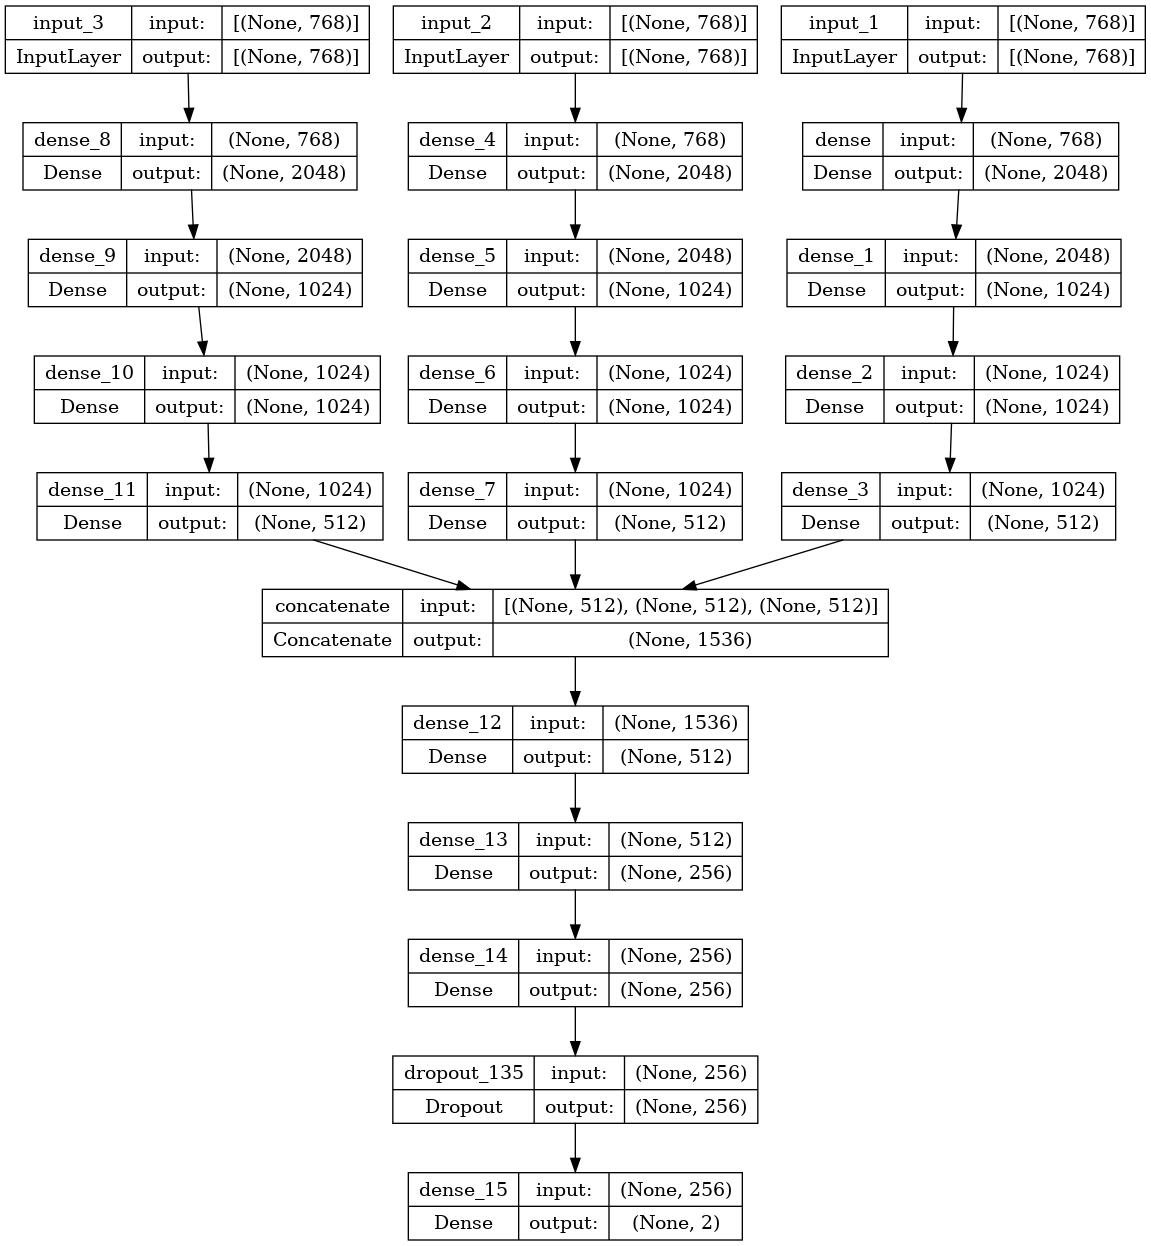

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [17]:
from sklearn.model_selection import train_test_split
X_train_f, X_test_f,X_train_x, X_test_x,X_train_b, X_test_b, y_train, y_test = train_test_split(OP_funnel,OP_XLN, OP_BERT,Y, random_state=42, test_size=0.2)
print('Train data    :'+str(X_train_f.shape), X_train_b.shape, str(X_train_x.shape))
print('Test data     :'+str(X_test_f.shape), str(X_test_b.shape), str(X_test_x.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(7200, 768) (7200, 768) (7200, 768)
Test data     :(1800, 768) (1800, 768) (1800, 768)
Train Output  :(7200, 2)
Test Output   :(1800, 2)


In [18]:
METRICS = [
               'accuracy'
        ]  
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./',
                save_weights_only=True,
                monitor='accuracy',
                mode='max',
                save_best_only=True)
model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=METRICS
            )
history = model.fit([OP_funnel, OP_XLN, OP_BERT], Y,
                            epochs=100,
                            verbose=1,
                            shuffle = True,
                            validation_data=([X_test_f,X_test_x,X_test_b],y_test),
                           callbacks=[model_checkpoint_callback])

Epoch 1/100
282/282 [==============================] - 10s 12ms/step - loss: 0.6608 - accuracy: 0.6263 - val_loss: 0.6440 - val_accuracy: 0.6356
Epoch 2/100
282/282 [==============================] - 3s 9ms/step - loss: 0.6467 - accuracy: 0.6321 - val_loss: 0.6450 - val_accuracy: 0.6594
Epoch 3/100
282/282 [==============================] - 3s 10ms/step - loss: 0.6345 - accuracy: 0.6479 - val_loss: 0.6175 - val_accuracy: 0.6606
Epoch 4/100
282/282 [==============================] - 3s 10ms/step - loss: 0.6196 - accuracy: 0.6646 - val_loss: 0.5926 - val_accuracy: 0.6911
Epoch 5/100
282/282 [==============================] - 3s 11ms/step - loss: 0.6123 - accuracy: 0.6672 - val_loss: 0.5958 - val_accuracy: 0.6872
Epoch 6/100
282/282 [==============================] - 3s 9ms/step - loss: 0.5996 - accuracy: 0.6782 - val_loss: 0.5838 - val_accuracy: 0.6917
Epoch 7/100
282/282 [==============================] - 3s 12ms/step - loss: 0.5819 - accuracy: 0.6920 - val_loss: 0.5781 - val_accuracy: 

In [19]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
name ='Model_CB256'
with open(name+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(name+".h5")
import pandas as pd
json_file = open('./'+name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('./'+name+'.h5')
print("Loaded model from disk")
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(name+'.csv',index = False)
hist_df.tail()

Loaded model from disk


,loss,accuracy,val_loss,val_accuracy
95,0.214912,0.855111,0.227066,0.869444
96,0.233839,0.851778,0.201922,0.863889
97,0.211425,0.858111,0.242273,0.860556
98,0.216526,0.856444,0.199528,0.857778
99,0.203022,0.862333,0.193711,0.866667


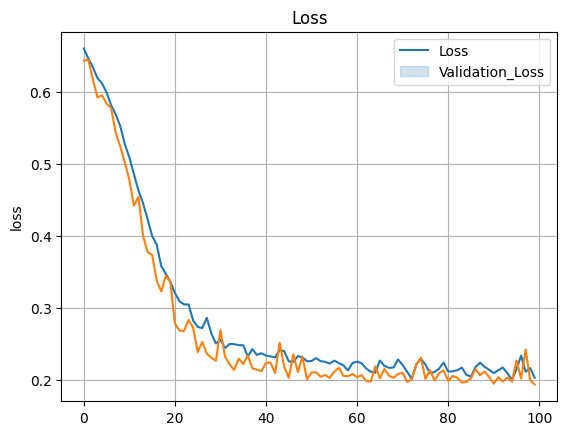

In [20]:
import seaborn as sns
sns.lineplot( x=hist_df.index, y=hist_df['loss'])
sns.lineplot( x=hist_df.index, y=hist_df['val_loss'])
plt.legend(['Loss','Validation_Loss'])
plt.title('Loss')
plt.grid()
plt.show()

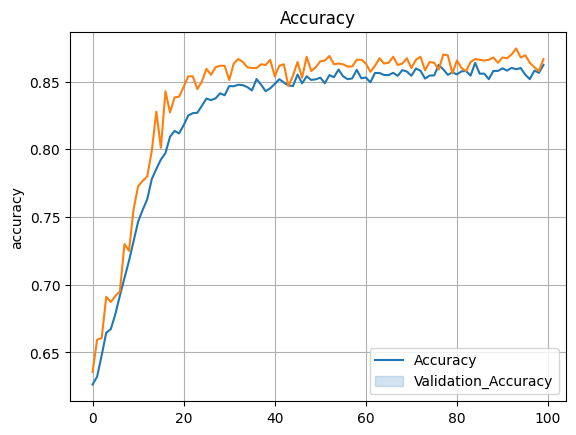

In [21]:
sns.lineplot( x=hist_df.index, y=hist_df['accuracy'])
sns.lineplot( x=hist_df.index, y=hist_df['val_accuracy'])
plt.legend(['Accuracy','Validation_Accuracy'])
plt.title('Accuracy')
plt.grid()
plt.show()

In [22]:
def view_score(score):
    for i in range(len(score)):
        print(loaded_model.metrics_names[i]+" : "+str(score[i]))
METRICS = [
                'accuracy',
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()
    
        ]   
loaded_model.compile(
                optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([X_train_f,X_train_x,X_train_b],y_train, verbose=0)
view_score(score)

loss : 0.19529858231544495
accuracy : 0.8659722208976746
recall : 0.9795833230018616
auc : 0.9626367092132568


In [23]:
classes = ['Acceptable', 'Hateful']
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
def pred(X,Y):
    yhat = loaded_model.predict(X)
    yhat = enc.inverse_transform(yhat)
    y_real = enc.inverse_transform(Y)
    return y_real,yhat
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
def visualise(y_true,y_pred,name,model_name):
    ConfusionM = confusion_matrix(y_true,y_pred)

    
    #print('ROC AUC score:', 
    #multiclass_roc_auc_score(y_true,y_pred, ))
    print(classification_report(y_true,y_pred  ,target_names = classes,digits=4))
    print()
    fig, ax = plt.subplots(figsize=(16,16)) 
    import seaborn as sns
    sns.heatmap(ConfusionM, annot=True,cmap = 'Greys',xticklabels=classes, yticklabels=classes, fmt='.2f')
    plt.title('Confusion Matrix for '+model_name)
    plt.savefig('CM.jpg')
    plt.show()
from sklearn.metrics import multilabel_confusion_matrix

def classwise(yt,yp,classes,name):
    op = multilabel_confusion_matrix(yt,yp)
    classwise_score = pd.DataFrame()
    j = 0
    for i in op:
        tp,fn,fp,tn = i[0][0],i[0][1],i[1][0],i[1][1]
        acc = (tp+tn)/(tp+tn+fp+fn)
        pre = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1 = 2*rec*pre / (rec +pre)
        sp = tn / (tn +fp)
        Po = (tp + tn) / (tp + tn + fp + fn)
        Pe = ((tp + fn) * (tp + fp) + (fp + tn) * (fn + tn)) / (tp + tn + fp + fn)**2
        # return dictionary
        kp = (Po - Pe) / (1 - Pe)
        classwise_score=classwise_score.append({
            'class' : classes[j],
                'TN':tn,'FP':fp,'FN':fn,'TP':tp,
                'Accuracy':acc,
                'Precision':pre,
                'Recall or Sensitivity':rec,
                'F1 Score':f1,
                'Specificity':sp
            },ignore_index=True)
        j = j + 1
    classwise_score.to_csv(name+'.csv')
    dft = classwise_score.describe()
    dft.to_csv(name+'_stats.csv')
    print(dft)
    return classwise_score
rdf = pd.DataFrame()


225/225 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

  Acceptable     0.9095    0.8753    0.8921      4556
     Hateful     0.7982    0.8498    0.8232      2644

    accuracy                         0.8660      7200
   macro avg     0.8538    0.8626    0.8576      7200
weighted avg     0.8686    0.8660    0.8668      7200




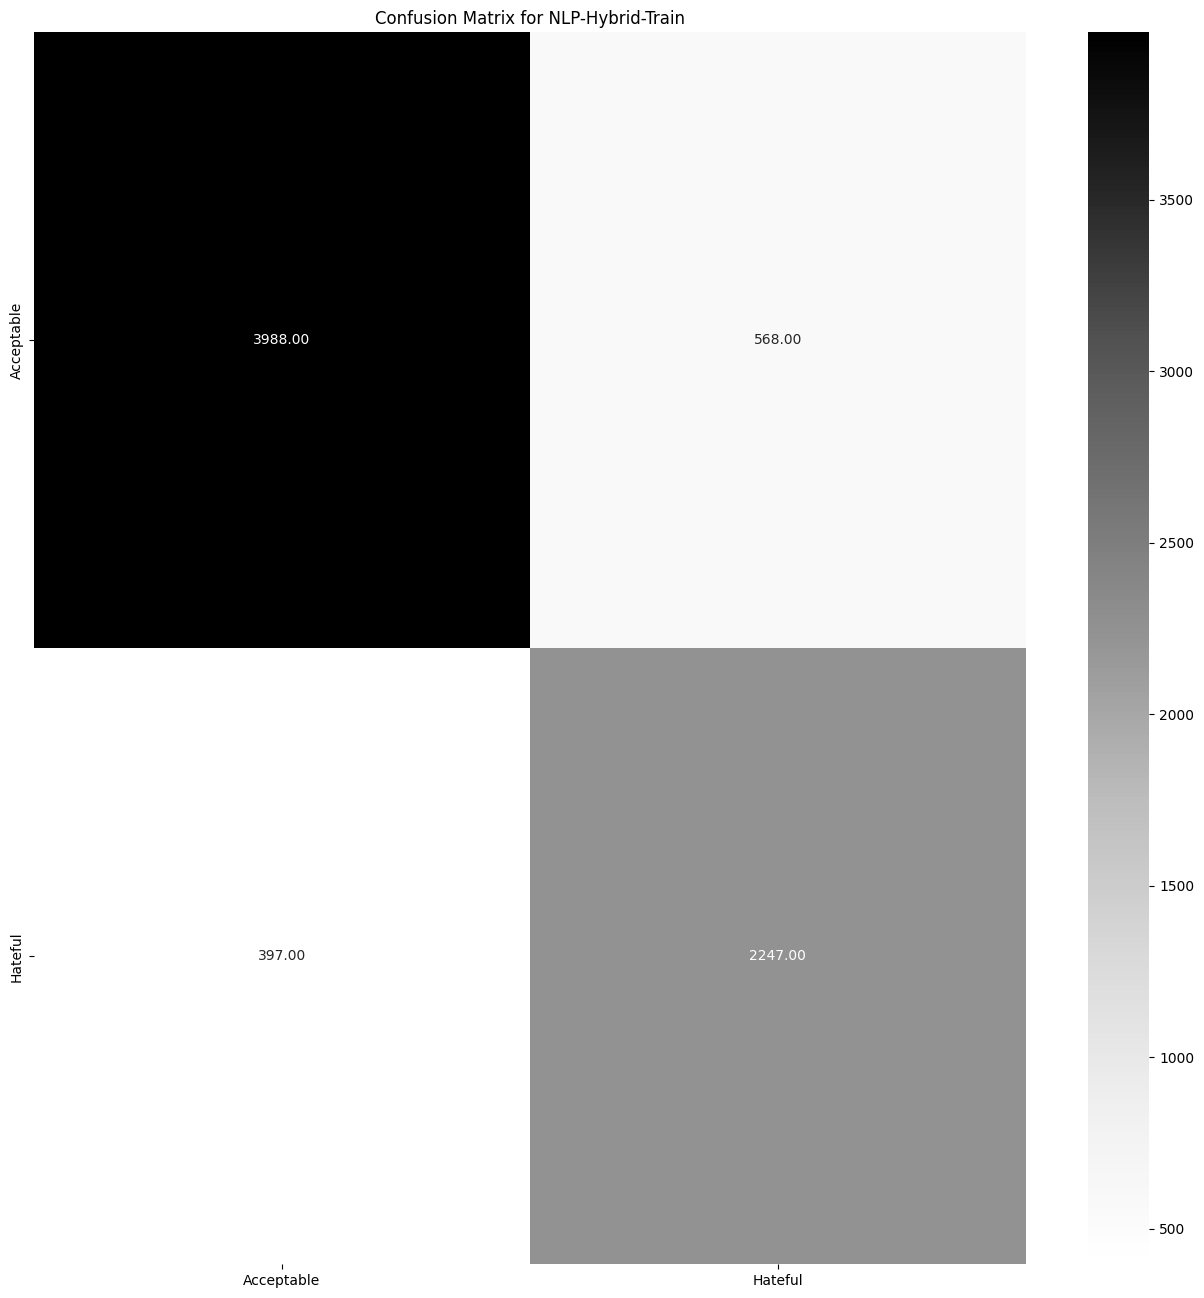

In [24]:
yt,yp = pred([X_train_f,X_train_x,X_train_b],y_train)
visualise(yt,yp,name,'NLP-Hybrid-Train')


57/57 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

  Acceptable     0.9154    0.8706    0.8925      1144
     Hateful     0.7921    0.8598    0.8246       656

    accuracy                         0.8667      1800
   macro avg     0.8538    0.8652    0.8585      1800
weighted avg     0.8705    0.8667    0.8677      1800




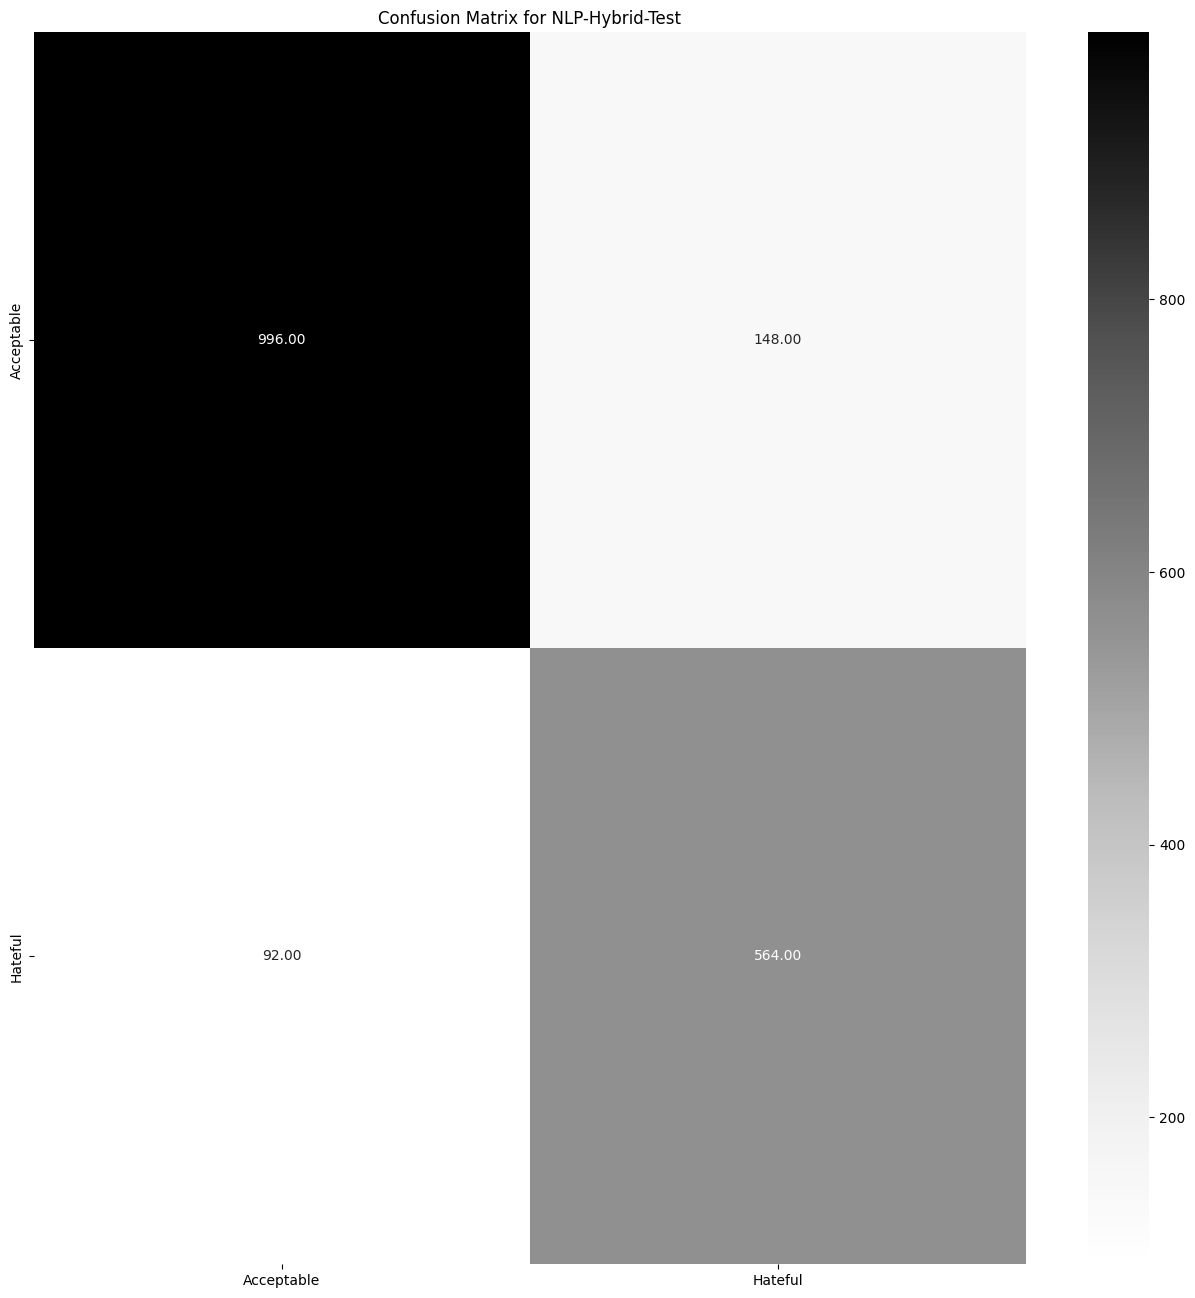

In [25]:
yt,yp = pred([X_test_f,X_test_x,X_test_b],y_test)
visualise(yt,yp,name,'NLP-Hybrid-Test')

# Cross validation

In [37]:
def onevsall(y_true,y_pred,mod):
    
    from sklearn.metrics import confusion_matrix
    global rdf
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*rec*pre / (rec +pre)
    sp = tn / (tn +fp)
    new_data = {
    'Model': mod,
    'TN': tn,
    'FP': fp,
    'FN': fn,
    'TP': tp,
    'Accuracy': acc,
    'Precision': pre,
    'Recall or Sensitivity': rec,
    'F1 Score': f1,
    'Specificity': sp
    }

    # Create a new DataFrame with the new data
    new_df = pd.DataFrame(new_data, index=[0])

    # Concatenate the new DataFrame with the existing one
    rdf = pd.concat([rdf, new_df], ignore_index=True)
        
    return rdf

def roc(clf,x,y):
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    skplt.metrics.plot_roc_curve(clf,x,y)
    plt.savefig('ROC'+model_name+'.jpg')
    plt.show()
    
def visualise(y_true,y_pred,name,model_name):
    ConfusionM = confusion_matrix(y_true,y_pred)

    #print('ROC AUC score:', 
    #multiclass_roc_auc_score(y_true,y_pred, ))
    print(classification_report(y_true,y_pred,   digits=4))
    print()
#     fig, ax = plt.subplots(figsize=(6,4)) 
#     import seaborn as sns
#     sns.heatmap(ConfusionM, annot=True,
#             fmt='g',xticklabels=name, yticklabels=name)
#     plt.title('Confusion Matrix for '+model_name)
#     plt.savefig('CM_'+model_name+'.jpg')
#     plt.show()
    return onevsall(y_true,y_pred,model_name)

In [38]:
from sklearn.model_selection import ShuffleSplit
from tqdm import tqdm
montecarlo_rns = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
j = 1
montedf = pd.DataFrame()
for a, b in tqdm(montecarlo_rns.split(X_test_f)):
    X_t = [X_test_f[a],X_test_x[a], X_test_b[a]]
    Y_t = y_test[a]
    
    rdf = pd.DataFrame()
    k= 0
    yt,yp = pred(X_t,Y_t)
    onevsall(yt,yp,'Hybrid Lingusitic Model')
    k = k + 1
    rdf['Monte_Carlo_iteration']='Iteration_'+str(j)
    montedf = pd.concat([montedf,rdf])
    j = j + 1

0it [00:00, ?it/s]

45/45 [==============================] - 0s 2ms/step


1it [00:00,  4.88it/s]

45/45 [==============================] - 0s 2ms/step


2it [00:00,  5.15it/s]

45/45 [==============================] - 0s 2ms/step


3it [00:00,  5.28it/s]

45/45 [==============================] - 0s 2ms/step


4it [00:00,  5.19it/s]

45/45 [==============================] - 0s 2ms/step


5it [00:00,  4.92it/s]

45/45 [==============================] - 0s 3ms/step


6it [00:01,  4.71it/s]

45/45 [==============================] - 0s 2ms/step


7it [00:01,  4.76it/s]

45/45 [==============================] - 0s 2ms/step


8it [00:01,  4.89it/s]

45/45 [==============================] - 0s 3ms/step


9it [00:01,  4.84it/s]

45/45 [==============================] - 0s 2ms/step


10it [00:02,  4.88it/s]


In [39]:
print(montedf.shape)
montedf

(10, 11)


,Model,TN,FP,FN,TP,Accuracy,Precision,Recall or Sensitivity,F1 Score,Specificity,Monte_Carlo_iteration
0,Hybrid Lingusitic Model,786,118,73,463,0.867361,0.796902,0.863806,0.829006,0.869469,Iteration_1
0,Hybrid Lingusitic Model,809,114,72,445,0.870833,0.796064,0.860735,0.827138,0.876490,Iteration_2
0,Hybrid Lingusitic Model,794,116,73,457,0.868750,0.797557,0.862264,0.828649,0.872527,Iteration_3
0,Hybrid Lingusitic Model,801,119,69,451,0.869444,0.791228,0.867308,0.827523,0.870652,Iteration_4
0,Hybrid Lingusitic Model,805,120,70,445,0.868056,0.787611,0.864078,0.824074,0.870270,Iteration_5
0,Hybrid Lingusitic Model,793,113,73,461,0.870833,0.803136,0.863296,0.832130,0.875276,Iteration_6
0,Hybrid Lingusitic Model,793,123,72,452,0.864583,0.786087,0.862595,0.822566,0.865721,Iteration_7
0,Hybrid Lingusitic Model,800,106,77,457,0.872917,0.811723,0.855805,0.833181,0.883002,Iteration_8
0,Hybrid Lingusitic Model,800,118,80,442,0.862500,0.789286,0.846743,0.817006,0.871460,Iteration_9
0,Hybrid Lingusitic Model,793,124,69,454,0.865972,0.785467,0.868069,0.824705,0.864776,Iteration_10


In [40]:
montedf.to_csv('CV_hybridLiguistic.csv', index = False)

In [41]:
!zip -r OP.zip ./

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: Model_CB256.json (deflated 92%)
  adding: .data-00000-of-00001 (deflated 21%)
  adding: Model_CB256.h5 (deflated 8%)
  adding: checkpoint (deflated 34%)
  adding: .index (deflated 73%)
  adding: .virtual_documents/ (stored 0%)
  adding: Model_CB256.csv (deflated 59%)
  adding: CV_hybridLiguistic.csv (deflated 57%)
  adding: model.png (deflated 16%)
  adding: CM.jpg (deflated 75%)
